# 👁‍🗨 Visualizing Convolutional Layers in CNN

Convolutional Neural Networks are now widely used for image predictions. It permits to extract features and take into account the proximity of pixels compared to a standard neural network.

But these models remain opaque as *black boxes*. This notebook aims to highlight their operation in a visual way.

# Getting Started

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Model

In order to visualize the convolutional layers, a model is needed. Fortunately, keras includes pre-fitted models such as the VGG16 and that can be downloaded.

It was trained for the *ImageNet Large Scale Visual Recognition Challenge* in 2014.

In [2]:
# Load VGG16 model
model = tf.keras.applications.vgg16.VGG16()

2022-10-17 08:36:41.174201: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


553476096/553467096 [==============================] - 11s 0us/step


In [3]:
# Layers inside the model
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Visualize Filters

The best way to do it is to get the filters and apply them directly to the image. The filters are basically 2D-shape weight values.

In [4]:
# Filter shapes of the layers
for layer in model.layers:
    if 'conv' not in layer.name:
        continue
    filters, biases = layer.get_weights()
    print("Name:", layer.name, "| Shape:", filters.shape)

Name: block1_conv1 | Shape: (3, 3, 3, 64)
Name: block1_conv2 | Shape: (3, 3, 64, 64)
Name: block2_conv1 | Shape: (3, 3, 64, 128)
Name: block2_conv2 | Shape: (3, 3, 128, 128)
Name: block3_conv1 | Shape: (3, 3, 128, 256)
Name: block3_conv2 | Shape: (3, 3, 256, 256)
Name: block3_conv3 | Shape: (3, 3, 256, 256)
Name: block4_conv1 | Shape: (3, 3, 256, 512)
Name: block4_conv2 | Shape: (3, 3, 512, 512)
Name: block4_conv3 | Shape: (3, 3, 512, 512)
Name: block5_conv1 | Shape: (3, 3, 512, 512)
Name: block5_conv2 | Shape: (3, 3, 512, 512)
Name: block5_conv3 | Shape: (3, 3, 512, 512)


In [5]:
# Scale between 0 and 1
scaler = MinMaxScaler()
filters, biases = model.layers[1].get_weights()
filters = scaler.fit_transform(filters.reshape(-1, 1)).reshape(filters.shape)

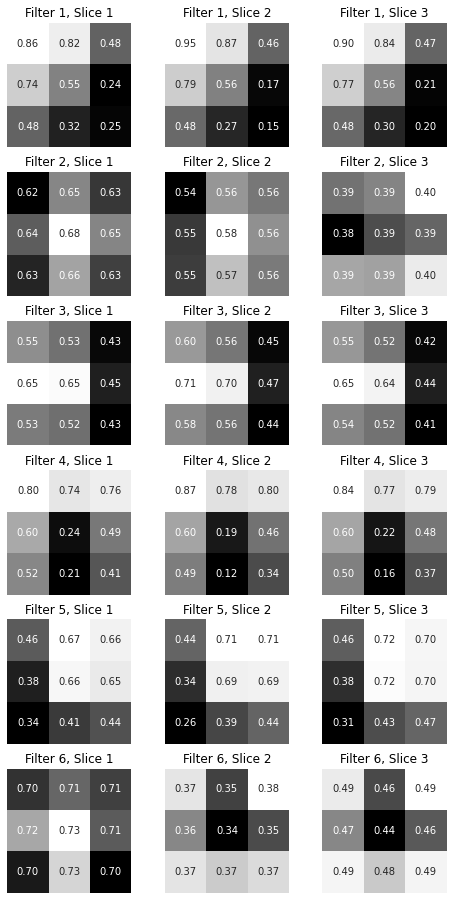

In [6]:
# Display the 6 first filters (3x3x3 filters)
plt.figure(figsize=(8, 16))

n = 0
for i in range(6):
    for j in range(3):
        plt.subplot(6, 3, n+1)
        sns.heatmap(filters[:, :, j, i], cmap='gray', square=True, cbar=False, annot=True, fmt='.2f')
        plt.title(f"Filter {i+1}, Slice {j+1}")
        plt.axis('off')
        n += 1
        
plt.show()

# Visualize Transformations

Let's load an image to see what occurs after the application of filters.

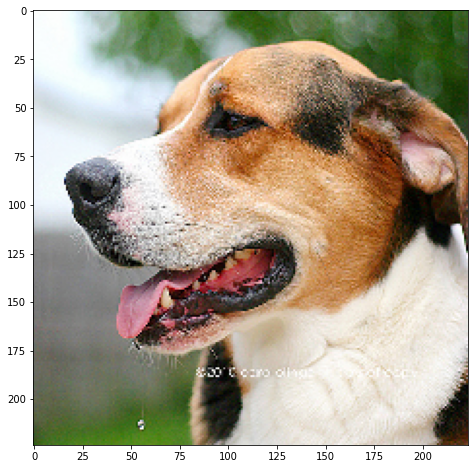

In [7]:
image = tf.keras.preprocessing.image.load_img('../input/imagenet/imagenet/val/ILSVRC2012_val_00000028.JPEG', target_size=(224, 224))
image = np.array(image)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()

image = np.expand_dims(image, axis=0)

In [8]:
# What the model predicts
prediction = model.predict(image)
print("Prediction:", prediction.argmax())
print("Probability:", prediction.max())

2022-10-17 08:36:59.313637: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Prediction: 180
Probability: 0.78882027


The labels to the classes are found here: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

*180* is labeled to **"Staffordshire bullterrier, Staffordshire bull terrier'"**

This is a good prediction by the model.

In [9]:
# Convolutional layer shapes
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)


In order to visualize what happened after a convolutional layer, we must redefine the model outputs right after an hidden layer.

The feature map can be obtain by running the prediction of the redefined model. It will give for example 64 images of 224 x 224 at the end of the first block, 128 at the end of the second block, etc.

The different blocks end respectively at the layers 2, 5, 9, 13 and 17.

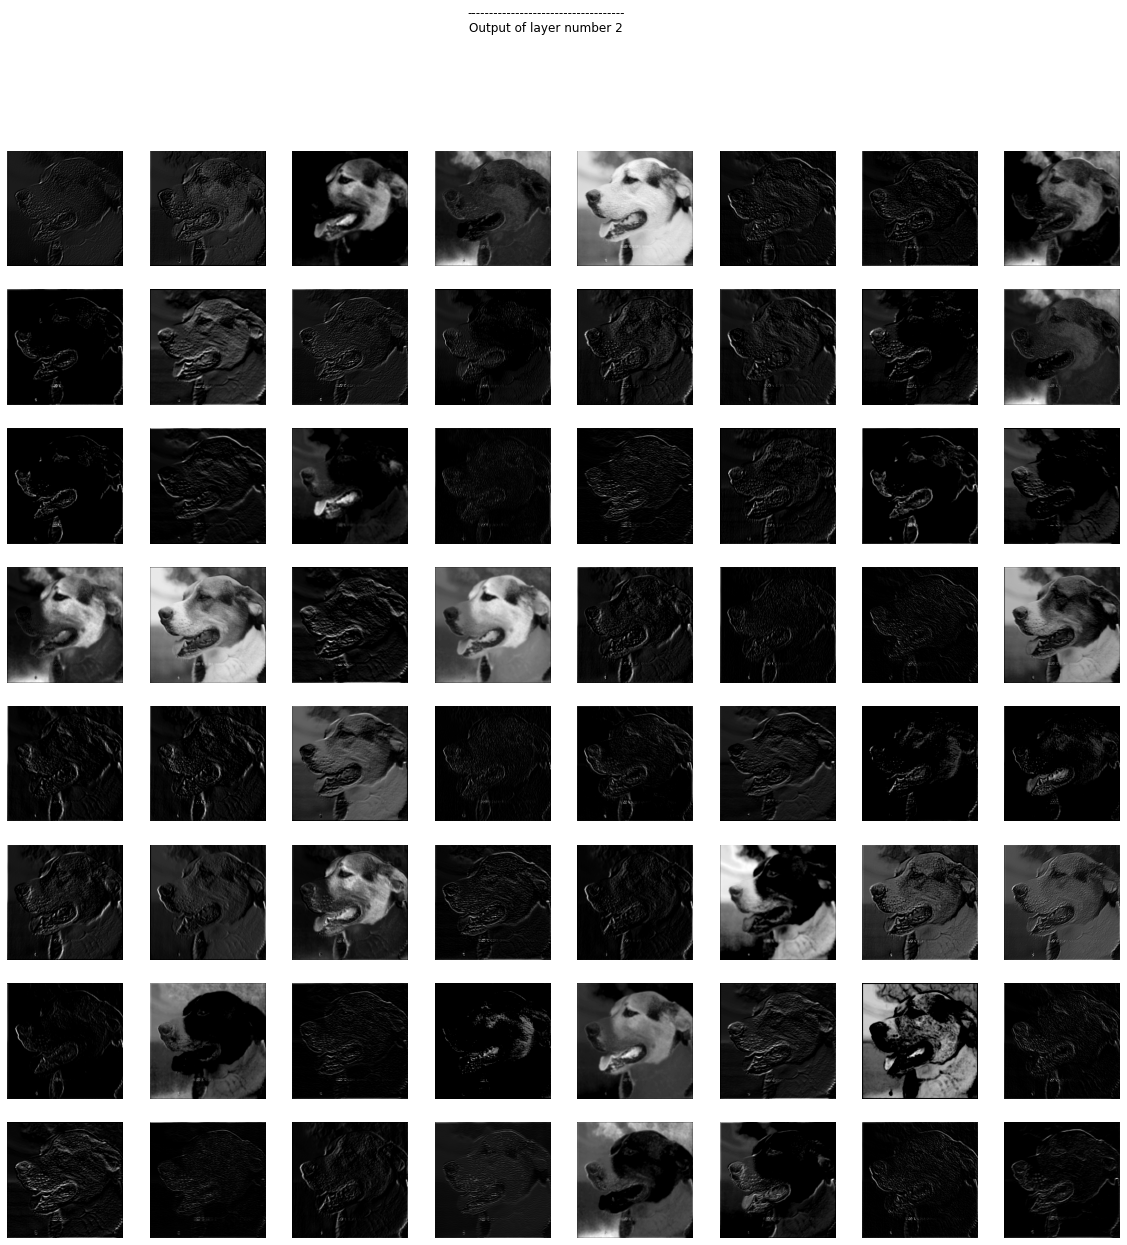

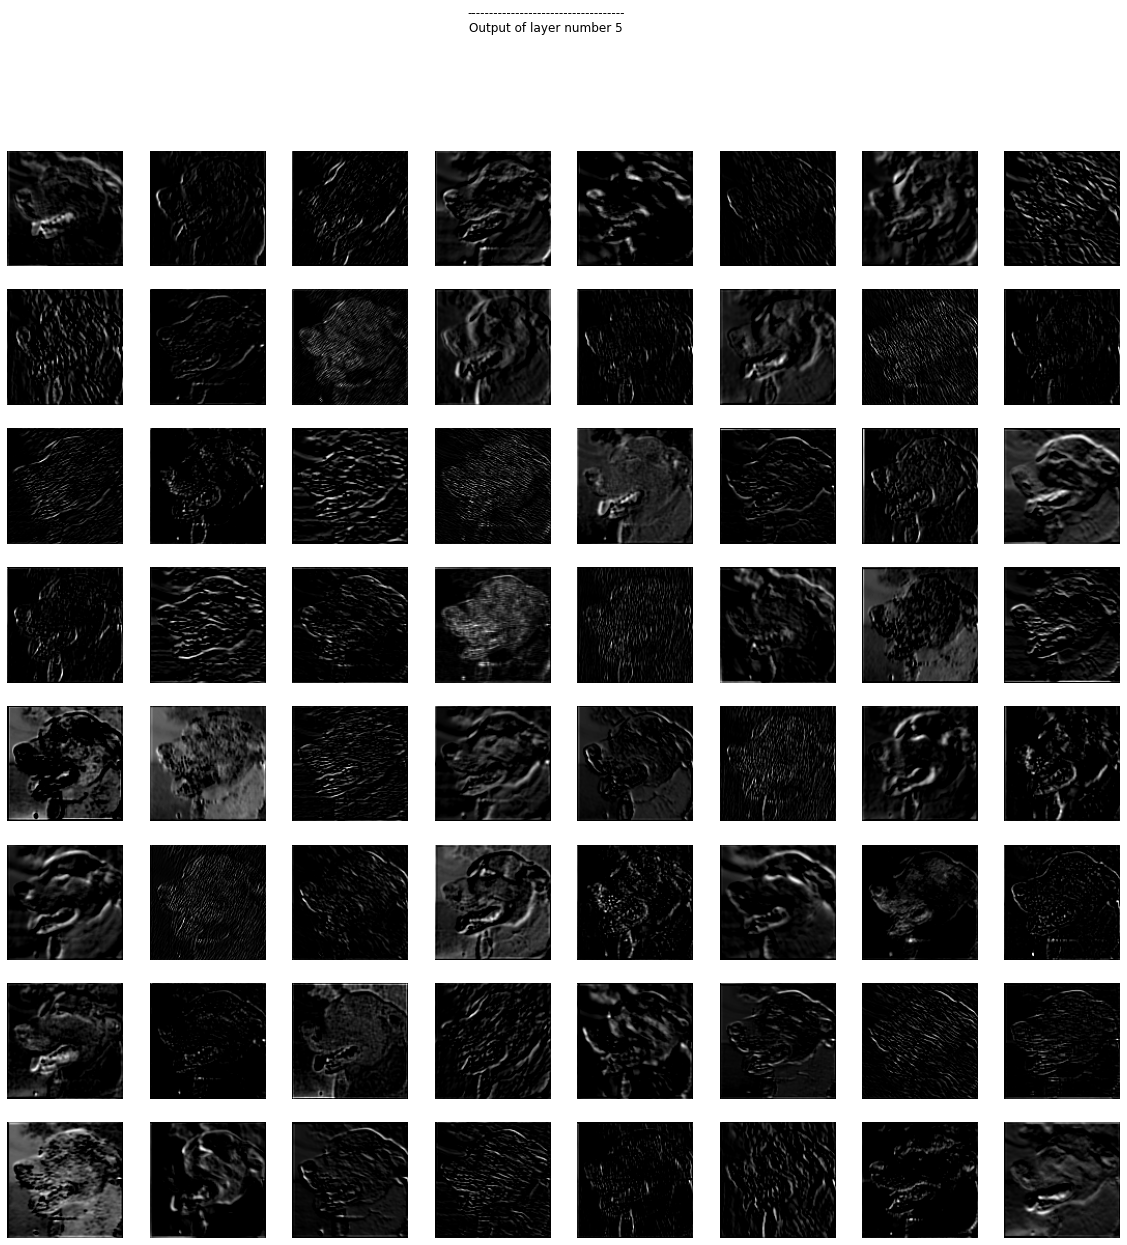

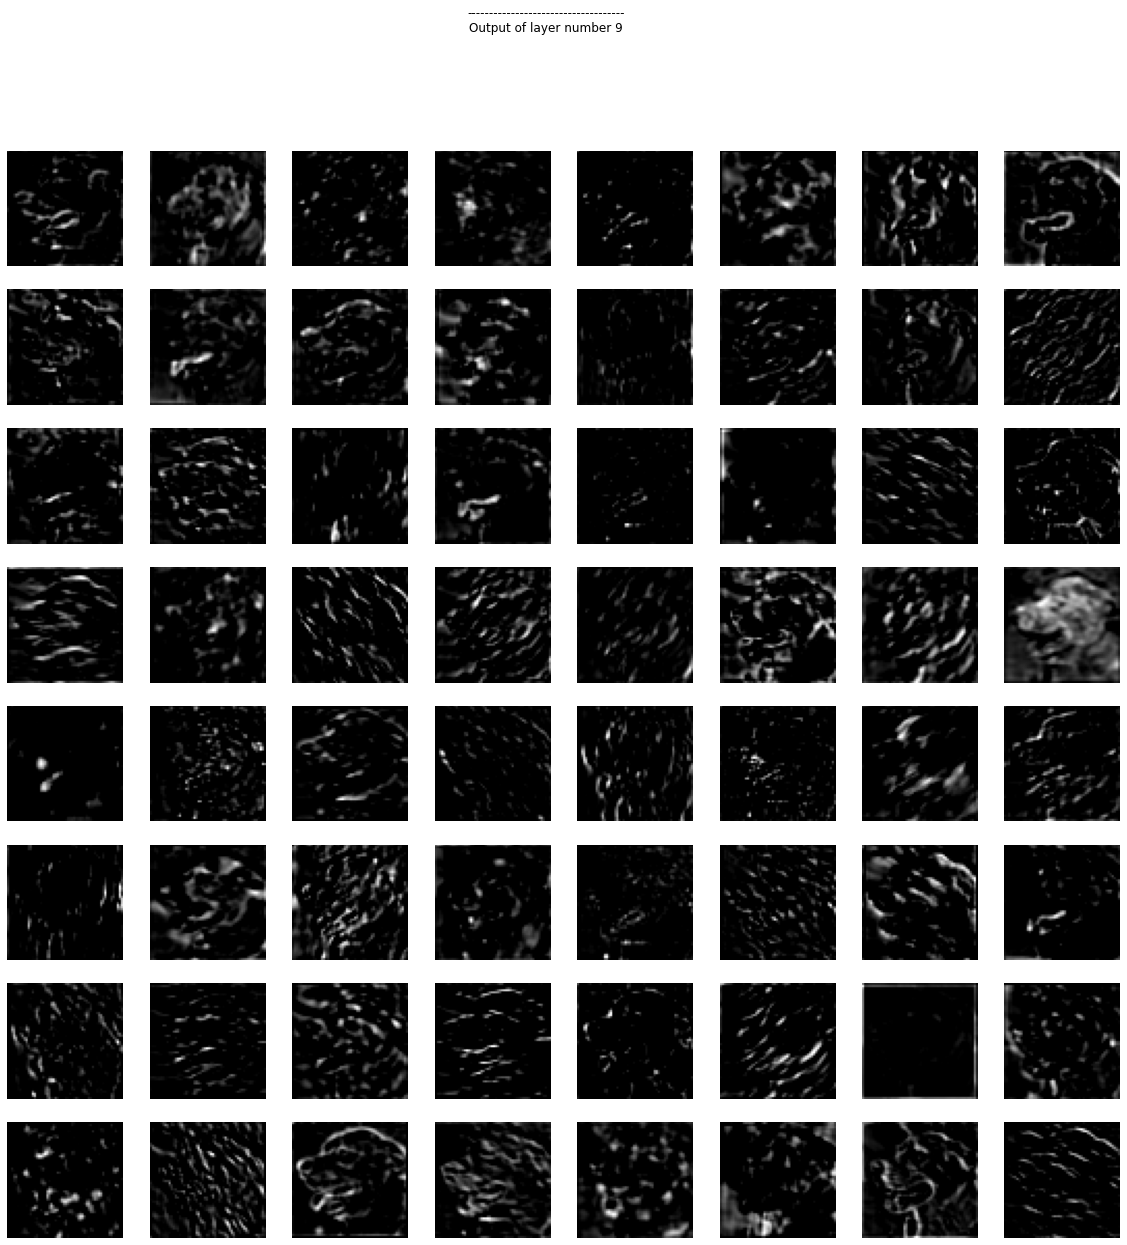

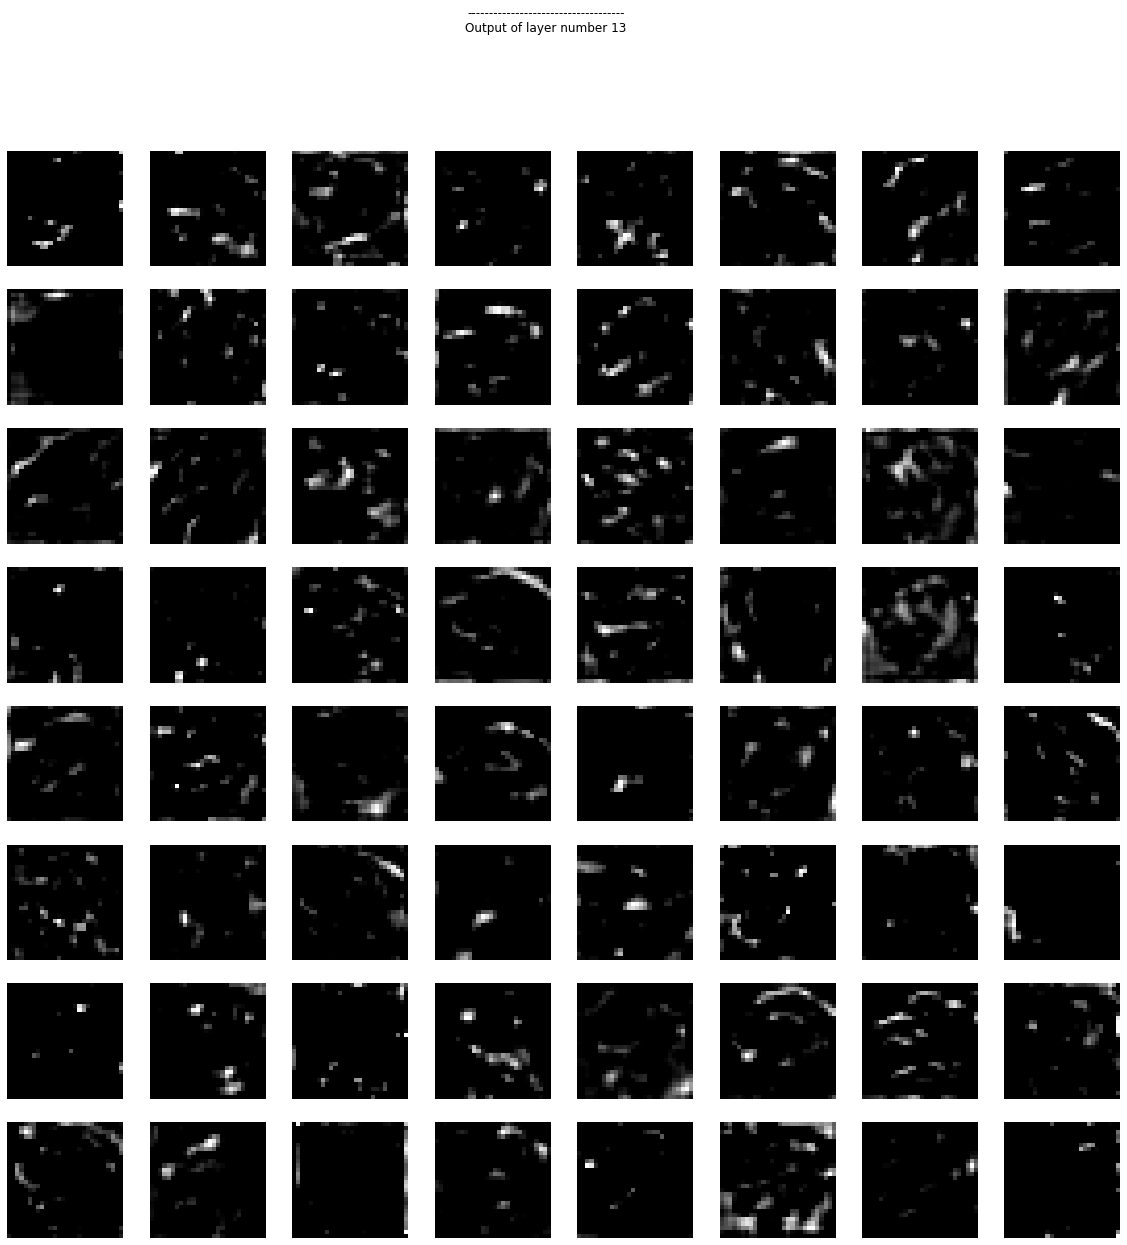

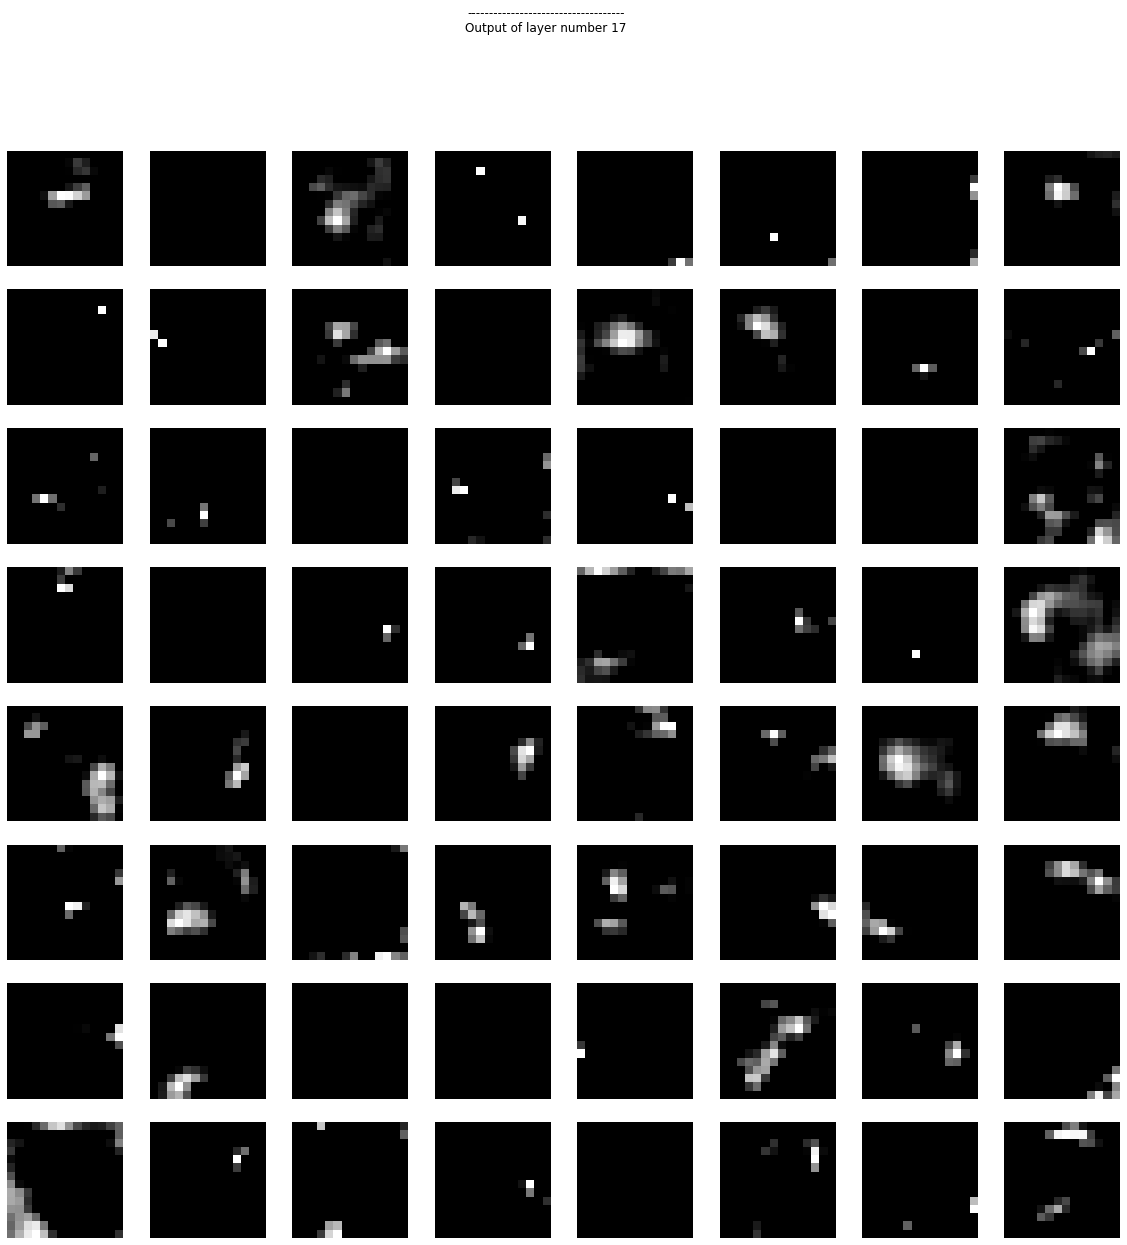

In [10]:
idx = [2, 5, 9, 13, 17]

for n in idx:
    
    # Redefine the model
    redefined_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[n].output)

    # Feature map of the first hidden layer
    feature_map = redefined_model.predict(image).squeeze()

    # Display the filtered images at the outputs of the blocks
    plt.figure(figsize=(20, 20))
    for i in range(64):
        plt.subplot(8, 8, i+1)
        plt.imshow(feature_map[:, :, i], cmap='gray')
        plt.axis('off')
        plt.suptitle(f"------------------------------------\nOutput of layer number {n}")
    plt.show()

The deeper we go into the model, the harder it is to figure out what the image is.

At the output of the two first blocks, it is possible to see a dog, but after the fifth block, we can only see lighted areas which does not give any information to a human being.

What is impressive is that the model can actually see this dog over the set of images.

Here not all filters are displayed after each block but in reality, it starts with 64 and it doubles until block 4 that generates 512 new images, like block 5.

At the same time, the image size is reduced and reaches 14x14 after block 5.

Notice that some images are completely black, but it still gives information about the result of the filter. 

Thank you very much for reading.

Please let me know if you have any suggestion about this work.

**Have a nice day!**